In [69]:
from pylab import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score, train_test_split

DATA_PATH = "D:/data/school/" # Make this the /path/to/the/data

# import data

In [2]:
data_class_size = pd.read_csv(DATA_PATH + "2010-2011_Class_Size_-_School-level_detail.csv")
data_graduation = pd.read_csv(DATA_PATH + "Graduation_Outcomes_-_Classes_Of_2005-2010_-_School_Level.csv")
data_sat_results = pd.read_csv(DATA_PATH + "SAT_Results.csv")
data_attendance = pd.read_csv(DATA_PATH + 'School_Attendance_and_Enrollment_Statistics_by_District__2010-11_.csv')
data_school_grade = pd.read_csv(DATA_PATH + 'School_Progress_Report_2010-2011.csv')
data_graduation_new = pd.read_csv(DATA_PATH + "Graduation_Outcomes_-_School_Level_-_Classes_2010-2011_-_Regents-based_Math_ELA_APM_-_Total_Cohort.csv")


# Data Clean

### Class size data

In [3]:
def add_DBN_to_class(row):
    dbn = "{0:02d}{1}".format(row["CSD"], row["SCHOOL CODE"])
    return dbn
    
data_class_size["DBN"] = data_class_size.apply(add_DBN_to_class, axis=1)

In [4]:
class_size_temp = data_class_size.drop(['CSD', 'BOROUGH', 'SCHOOL CODE'], 1)
class_size_temp = class_size_temp[class_size_temp["GRADE "] == '09-12']
class_size_temp = class_size_temp[class_size_temp["PROGRAM TYPE"] == 'GEN ED']
class_size_temp = class_size_temp.groupby("DBN").agg(np.mean)

In [25]:
data_class_size_final = class_size_temp.reset_index()
data_class_size_final = data_class_size_final[['DBN', 'AVERAGE CLASS SIZE']]

### SAT result

In [6]:
sat_results_temp = data_sat_results.drop("Num of SAT Test Takers", 1)
sat_results_temp['SAT Math Avg. Score'] = sat_results_temp['SAT Math Avg. Score'].convert_objects(convert_numeric = True)
sat_results_temp['SAT Critical Reading Avg. Score'] = sat_results_temp['SAT Critical Reading Avg. Score'].convert_objects(convert_numeric = True)
sat_results_temp['SAT Writing Avg. Score'] = sat_results_temp['SAT Writing Avg. Score'].convert_objects(convert_numeric = True)

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  from ipykernel import kernelapp as app
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  app.launch_new_instance()
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


In [7]:
sat_results_temp["Total_Avg"] = sat_results_temp.apply(lambda x: x['SAT Math Avg. Score'] + x['SAT Critical Reading Avg. Score'] + x['SAT Writing Avg. Score'], axis=1)

In [48]:
sat_results_temp = sat_results_temp.rename(columns={"Total_Avg":"SAT_Avg",})
sat_results_final = sat_results_temp[['DBN', 'SAT_Avg']]

### Attendance

In [42]:
attendance_temp = data_attendance
attendance_temp['District'] = data_attendance.apply(lambda x: x['District'].replace('DISTRICT ', ''), axis=1)
attendance_temp = attendance_temp.drop([33, 34])
attendance_temp['District'] = attendance_temp.apply(lambda x: x['District'].replace('SPECIAL ED ', ''), axis=1)
attendance_temp['YTD % Attendance (Avg)'] = attendance_temp.apply(lambda x: x['YTD % Attendance (Avg)'].replace('%', ''), axis=1)
attendance_temp = attendance_temp.rename(columns={'YTD % Attendance (Avg)':'Avg_ttendance', 'YTD Enrollment(Avg)':'Avg_enrollment'})


In [43]:
attendance_temp.dtypes

District          object
Avg_ttendance     object
Avg_enrollment     int64
dtype: object

In [44]:
attendance_temp = attendance_temp.rename(columns={'Avg_ttendance':"Avg_atendance" })
attendance_temp['Avg_atendance'] = attendance_temp['Avg_atendance'].convert_objects(convert_numeric = True)

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  from ipykernel import kernelapp as app


In [45]:
attendance_final = attendance_temp

### School grade data

In [12]:
school_grade_temp = data_school_grade[data_school_grade["SCHOOL LEVEL*"] == "High School"]

In [13]:
school_grade_temp = school_grade_temp.drop(["DISTRICT", "SCHOOL", "PRINCIPAL", "PROGRESS REPORT TYPE", "SCHOOL LEVEL*"], axis=1)

In [14]:
school_grade_final = school_grade_temp.rename(columns={'\ufeffDBN':'DBN'})

### Merge data

In [49]:
len(data_sat_results)

478

In [50]:
len(data_class_size_final)

583

In [51]:
sat_class_size = pd.merge(data_class_size_final, sat_results_final, how='inner', on='DBN')
sat_class_size = sat_class_size.dropna()

In [52]:
sat_class_size_temp = sat_class_size
sat_class_size_temp['District'] = sat_class_size_temp.apply(lambda x: x['DBN'][0:2], axis=1)

In [53]:
sat_size_atte = pd.merge(sat_class_size_temp, attendance_final, how='inner', on='District')

In [54]:
sat_size_atte_grade = pd.merge(sat_size_atte, school_grade_final, how='inner', on='DBN')

In [55]:
grade_remove_col = ["2010-2011 OVERALL GRADE", "2010-2011 ENVIRONMENT GRADE", "2010-2011 PERFORMANCE GRADE", "2010-2011 PROGRESS GRADE", "2010-2011 ADDITIONAL CREDIT", "2009-10 PROGRESS REPORT GRADE"]

In [56]:
sat_size_atte_grade_temp = sat_size_atte_grade.drop(grade_remove_col, axis=1)

In [57]:
sat_size_atte_grade_temp = sat_size_atte_grade_temp.dropna()


# Visualizing data

In [58]:
list(sat_size_atte_grade_temp.columns.values)

['DBN',
 'AVERAGE CLASS SIZE',
 'SAT_Avg',
 'District',
 'Avg_atendance',
 'Avg_enrollment',
 'PEER INDEX*',
 '2010-2011 OVERALL SCORE',
 '2010-2011 ENVIRONMENT CATEGORY SCORE',
 '2010-2011 PERFORMANCE CATEGORY SCORE',
 '2010-2011 PROGRESS CATEGORY SCORE']

In [59]:
sat_size_atte_grade_temp.dtypes

DBN                                      object
AVERAGE CLASS SIZE                      float64
SAT_Avg                                 float64
District                                 object
Avg_atendance                           float64
Avg_enrollment                            int64
PEER INDEX*                             float64
2010-2011 OVERALL SCORE                 float64
2010-2011 ENVIRONMENT CATEGORY SCORE    float64
2010-2011 PERFORMANCE CATEGORY SCORE    float64
2010-2011 PROGRESS CATEGORY SCORE       float64
dtype: object

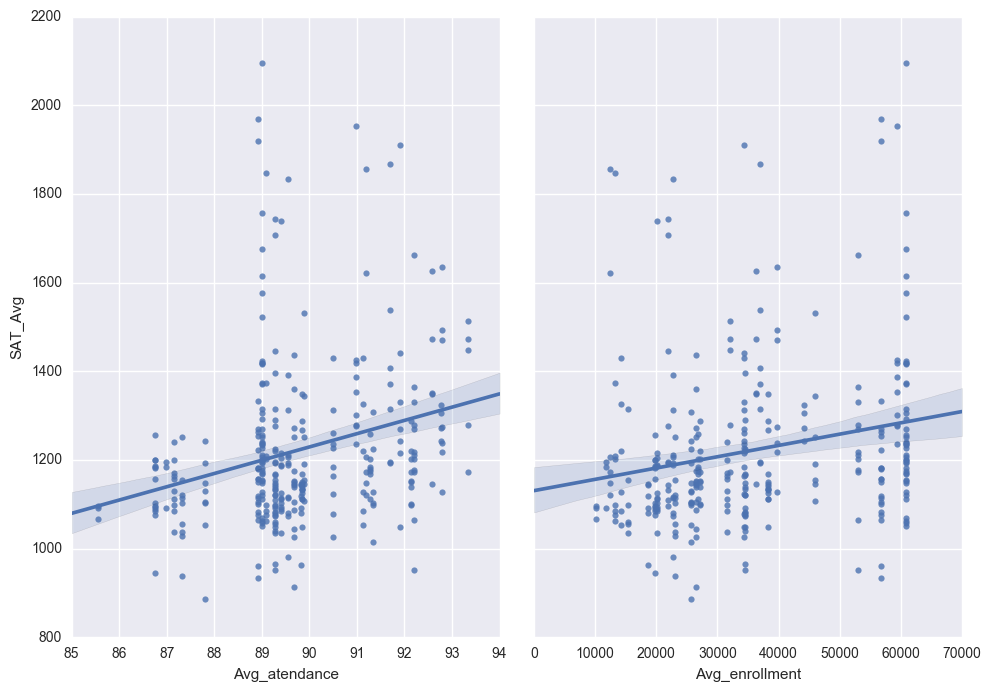

In [60]:
sns.pairplot(sat_size_atte_grade_temp, x_vars=[ 'Avg_atendance',
                                               'Avg_enrollment'],
             y_vars='SAT_Avg', size=7, aspect=0.7, kind='reg')

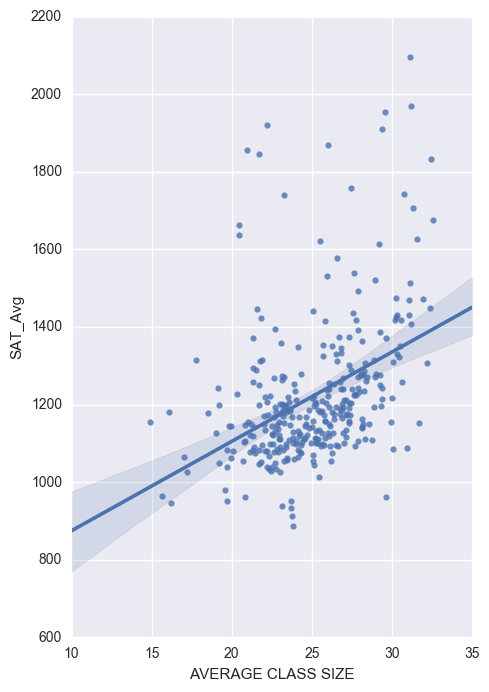

In [37]:
sns.pairplot(sat_size_atte_grade_temp, x_vars=['AVERAGE CLASS SIZE'],
             y_vars='SAT_Avg', size=7, aspect=0.7, kind='reg')

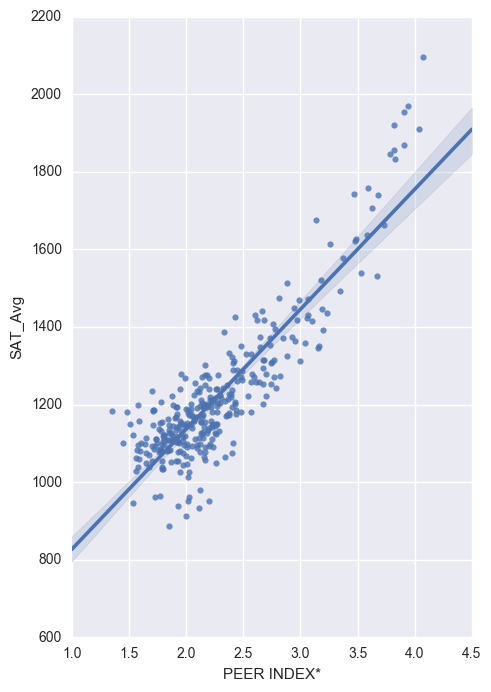

In [61]:
sns.pairplot(sat_size_atte_grade_temp, x_vars=['PEER INDEX*'],
             y_vars='SAT_Avg', size=7, aspect=0.7, kind='reg')

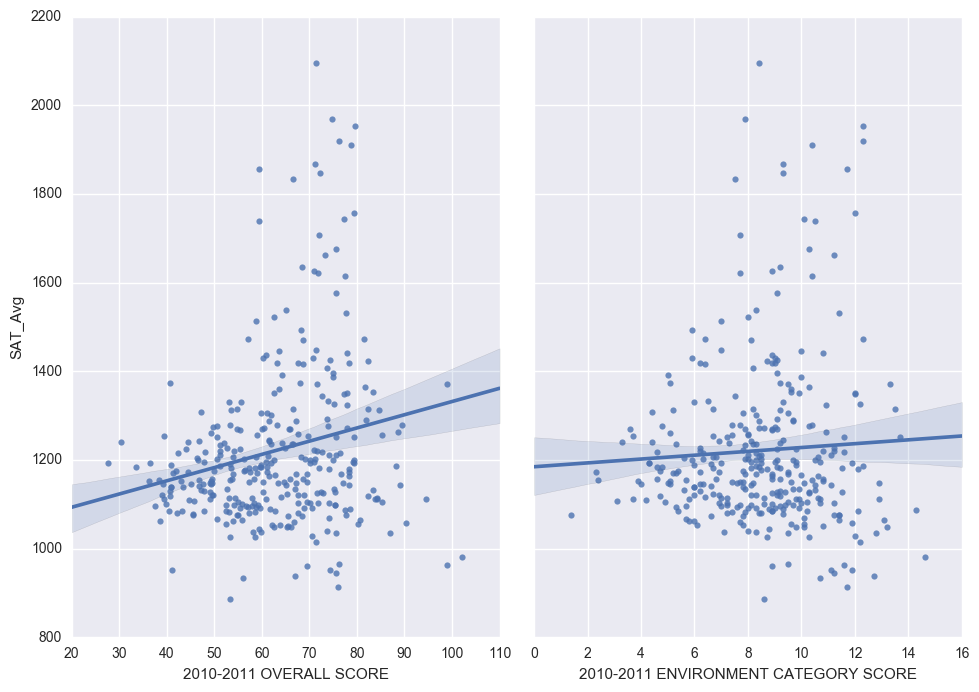

In [62]:
sns.pairplot(sat_size_atte_grade_temp, x_vars=['2010-2011 OVERALL SCORE',
                                               '2010-2011 ENVIRONMENT CATEGORY SCORE'],
             y_vars='SAT_Avg', size=7, aspect=0.7, kind='reg')

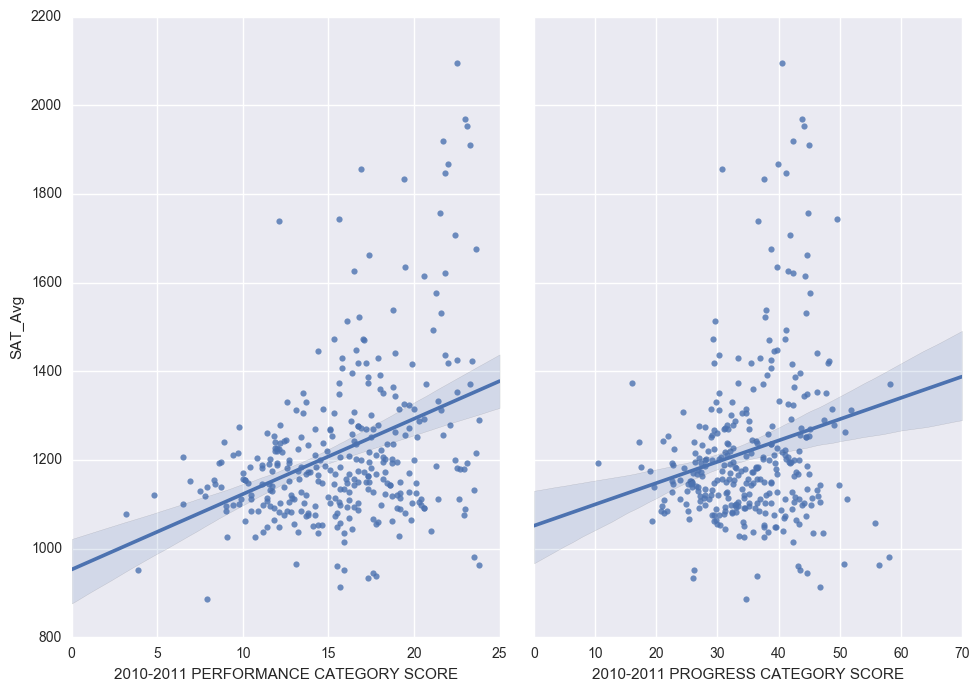

In [63]:
sns.pairplot(sat_size_atte_grade_temp, x_vars=['2010-2011 PERFORMANCE CATEGORY SCORE',
                                               '2010-2011 PROGRESS CATEGORY SCORE'],
             y_vars='SAT_Avg', size=7, aspect=0.7, kind='reg')

# Linear regression


In [64]:
feature_cols = ['AVERAGE CLASS SIZE','Avg_atendance','Avg_enrollment','PEER INDEX*', 
                '2010-2011 OVERALL SCORE','2010-2011 ENVIRONMENT CATEGORY SCORE',
                '2010-2011 PERFORMANCE CATEGORY SCORE','2010-2011 PROGRESS CATEGORY SCORE']

In [65]:
data_feature = sat_size_atte_grade_temp[feature_cols]

In [66]:
data_target = sat_size_atte_grade_temp['SAT_Avg']

In [67]:
data_feature.shape

(323, 8)

In [68]:
data_target.shape

(323,)

## cross validation

### LinearRegression

In [70]:
linear_reg = LinearRegression()
linreg_scores = cross_val_score(linear_reg, data_feature, data_target, cv=10, scoring='mean_squared_error')
mse_linreg_scores = -linreg_scores
rmse_linreg_scores = np.sqrt(mse_linreg_scores)
print(rmse_linreg_scores)

[ 102.24395677   59.12236988   90.30261835  100.84664724   87.2531547
   78.52114641   79.42218592   72.67914299   80.32337904   78.56719354]


In [71]:
print(rmse_linreg_scores.mean())

82.9281794831


### BayesianRidge

In [72]:
from sklearn.linear_model import BayesianRidge
bay_ridge = BayesianRidge()
bay_ridge_scores = cross_val_score(bay_ridge, data_feature, data_target, cv=10, scoring='mean_squared_error')
mse_bay_ridge_scores = -bay_ridge_scores
rmse_bay_ridge_scores = np.sqrt(mse_bay_ridge_scores)
rmse_bay_ridge_scores
rmse_bay_ridge_scores.mean()

82.920231518837952

###  Ridge Regression

In [73]:
from sklearn.linear_model import Ridge, RidgeCV
ridge_reg = Ridge(alpha = .1)
ridge_reg_scores = cross_val_score(ridge_reg, data_feature, data_target, cv=5, scoring='mean_squared_error')
rmse_ridge_reg_scores = np.sqrt(-ridge_reg_scores)
rmse_ridge_reg_scores.mean()

83.787356818127918

### Lasso

In [74]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha = 0.1)
lasso_reg_scores = cross_val_score(lasso_reg, data_feature, data_target, cv=5, scoring='mean_squared_error')
rmse_lasso_reg_scores = np.sqrt(-lasso_reg_scores)
rmse_lasso_reg_scores.mean()

83.78124685266279

### predict SAT Score by using Linear regression

In [75]:
X_train, X_test, y_train, y_test = train_test_split(data_feature, data_target, random_state=1)

In [76]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(242, 8)
(242,)
(81, 8)
(81,)


In [77]:
# instantiate
linreg = LinearRegression()

# fit the model to the training data (learn the coefficients)
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [78]:
linreg.score(X_train, y_train)

0.80641956439190243

In [79]:
linreg.score(X_test, y_test)

0.83941470683529418

In [80]:
predict_sat = linreg.predict(X_test)

In [84]:
predict_sat

array([  989.53378268,  1036.6444607 ,  1714.39000827,  1067.73177634,
        1123.7424636 ,  1109.09489095,  1235.12568317,  1607.62560357,
        1301.83980401,  1206.17151921,  1117.98947602,  1157.45531852,
        1146.74096955,  1431.93193737,   915.20467821,   963.24402122,
        1184.11193381,  1121.44260802,  1228.57203999,  1550.15670977,
        1011.61655296,  1082.59188434,  1093.45263336,  1233.92597009,
        1045.77535686,  1179.92480946,  1211.81588038,  1189.48486623,
        1608.41065284,  1301.75489372,  1130.80882253,  1046.02804274,
        1239.76571765,  1361.09759899,  1178.77443669,   985.40708387,
        1060.15396818,  1083.62173073,  1209.73577172,  1087.90732429,
        1011.1512101 ,  1272.55822689,  1047.80191989,  1175.17592132,
        1250.26012011,  1018.32119344,  1047.1400117 ,  1233.7455108 ,
        1198.13243953,  1048.41937747,  1378.61869726,  1346.856148  ,
        1239.93819964,  1154.60981583,  1221.89925412,  1612.67225972,
      

In [83]:
y_test.values

array([ 1029.,  1148.,  1868.,  1080.,  1127.,   951.,  1206.,  1627.,
        1348.,  1177.,  1106.,  1064.,  1092.,  1514.,   945.,  1182.,
        1095.,  1176.,  1193.,  1522.,  1200.,  1112.,  1126.,  1210.,
        1158.,  1175.,  1269.,  1139.,  1663.,  1288.,  1045.,  1039.,
        1243.,  1431.,  1114.,  1060.,  1186.,  1121.,  1277.,  1051.,
        1062.,  1306.,  1055.,  1199.,  1315.,  1151.,  1184.,  1187.,
        1272.,  1096.,  1221.,  1330.,  1204.,  1169.,  1290.,  1538.,
        1910.,  1038.,  1333.,  1129.,  1621.,  1084.,  1090.,  1969.,
        1144.,  1111.,  1224.,  1176.,  1122.,  1147.,   962.,  1221.,
        1116.,  1135.,  1085.,  1202.,  1171.,  1424.,  1360.,  1185.,
        1391.])

In [85]:
len(predict_sat)


81

In [92]:
predict_x = [i for i in range(81)]

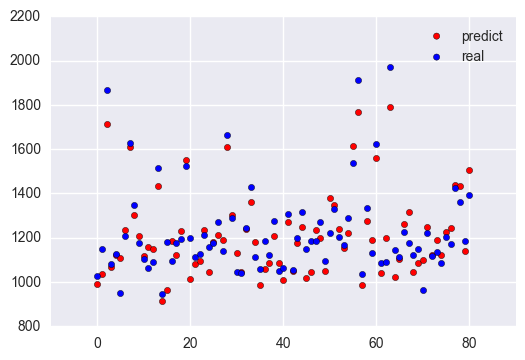

In [93]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(predict_x,predict_sat,c='r',label='predict')
ax.scatter(predict_x,y_test,c='b',label='real')
ax.legend()